In [1]:
import os
import sys
import matplotlib.pyplot as plt

os.chdir('..')

import numpy as np
import torch
import pandas as pd

from models.TrainPlanningOperator3D import PlanningOperator3D

from planners import generaterandompos
from planners import AStarPlanner, FMMPlanner, PlanningOperatorPlanner, testplanneronmaps, plot_2d_map_and_two_paths



Load Gibson Environment

In [2]:
Ntotal = 80

ntest = 16
ntrain = 8

sub = 1
Sx = 80
Sy = 80
Sz = 30

maps = np.load('dataset/occupancymaps.npy')
maps = maps[:Ntotal][:ntrain, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]
# maps = maps[0:8,:,:,:]
# maps = np.repeat(maps, repeats=5, axis=0)



Load Model

In [3]:


# Model
modes = 5
width = 24
nlayers = 1

model = PlanningOperator3D(modes, modes, modes, width, nlayers)
model.load_state_dict(torch.load("/mountvol/igib-hexpo-dataset-80-10g/planningoperator_env80_m8_w32_l1_b5_lr3e-3_10g_22sep/n640_lr3.000000e-03_gamma6.000000e-01_wd3.000000e-06_seed5/model3d.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/tmp/ipykernel_8162/1515835595.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/mountvol/igib-hexpo-dataset-80-10g/planningoperator_env

PlanningOperator3D(
  (fc0): Linear(in_features=3, out_features=24, bias=True)
  (conv0): SpectralConv3d()
  (w0): Conv3d(24, 24, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (fc1): DeepNormMetric(
    (Us): ModuleList(
      (0-1): 2 x Linear(in_features=24, out_features=128, bias=False)
    )
    (Ws): ModuleList(
      (0): ConstrainedLinear(in_features=128, out_features=128, bias=False)
    )
    (activation): MaxReLUPairwiseActivation(
      (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (output_activation): ConcaveActivation()
    (reduce_metric): ReduceMetric()
  )
)

Start [50 10 14]
Goal [45 14 14]

AStar
Success: False 
PathCost: inf 
PlanningTime: 4.04706883430481

FMM
Success: False 
PathCost: 0 
PlanningTime: 0.006693124771118164

Planning Operator
Success: False 
PathCost: 0 
Total Time 0.8187763690948486


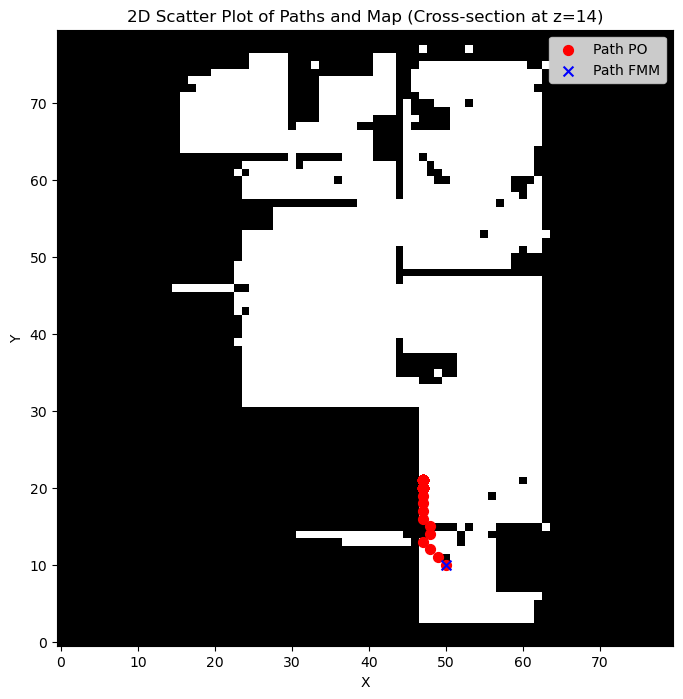

In [4]:
startpositions = generaterandompos(maps)
goalpositions = generaterandompos(maps)

mapx = maps[4,:,:,:]
startx = startpositions[0,:]
print("Start",startx)
goalx = goalpositions[0,:]
goalx[2] = startx[2]
print("Goal",goalx)


success,pathcost,planningtime, path = AStarPlanner(startx, goalx, mapx)

print("\nAStar\nSuccess:", success,
      "\nPathCost:", pathcost,
      "\nPlanningTime:",planningtime)


success,pathcost,planningtime, path_1 = FMMPlanner(startx, goalx, mapx)
print("\nFMM\nSuccess:", success,
      "\nPathCost:", pathcost,
      "\nPlanningTime:",planningtime)


success,pathcost,tot_time, path_2 = PlanningOperatorPlanner(startx, goalx, mapx, model)
print("\nPlanning Operator\nSuccess:", success,
      "\nPathCost:", pathcost,
      "\nTotal Time", tot_time)


plot_2d_map_and_two_paths(path_2,path_1,mapx,z_index=goalx[2])


Generate Random Positions

In [5]:
startpositions = generaterandompos(maps)
print(startpositions)
goalpositions = generaterandompos(maps)
goalpositions[0][2] = startpositions[0][2]
print(goalpositions)

[[37 19 17]
 [22 30 16]
 [47 15 14]
 [63 56  9]
 [35 41 19]
 [43 32  7]
 [18 36 13]
 [33 64 10]]
[[51 57 17]
 [24 52  7]
 [46 13 20]
 [47 48 19]
 [51 74  8]
 [20 59 16]
 [48 31 17]
 [76 38 16]]


In [6]:
testplanneronmaps(startpositions,goalpositions,maps,AStarPlanner,printvalues=True)

Average Path Cost: inf 
Average Planning Time: 0.2755540907382965 
Average Success Rate: 0.875


(inf, 0.2755540907382965, 0.875)

In [7]:
testplanneronmaps(startpositions,goalpositions,maps,FMMPlanner,printvalues=True)

Average Path Cost: 27.40143756486692 
Average Planning Time: 0.031978458166122437 
Average Success Rate: 0.875


(27.40143756486692, 0.031978458166122437, 0.875)

In [8]:
testplanneronmaps(startpositions,goalpositions,maps,PlanningOperatorPlanner,printvalues=True, model=model)

Average Path Cost: 18.685872280741183 
Average Planning Time: 0.2176862359046936 
Average Success Rate: 0.625


(18.685872280741183, 0.2176862359046936, 0.625)